# Predicting House Prices

**Sales prices prediction using an artificial neural network in Keras**

**Supervised Learning. Regression**

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import keras

helper.info_gpu()
sns.set_palette("GnBu_d")
#helper.reproducible(seed=0) # Setup reproducible results from run to run using Keras

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


/device:GPU:0
Keras		v2.1.4
TensorFlow	v1.4.1


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/house_prices_data.csv'
target = ['SalePrice']

df_original = pd.read_csv(data_path)

### Explore the data

In [3]:
helper.info_data(df_original, target)

Samples: 	1460 
Features: 	80
Target: 	SalePrice


In [4]:
df_original.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Missing values

['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

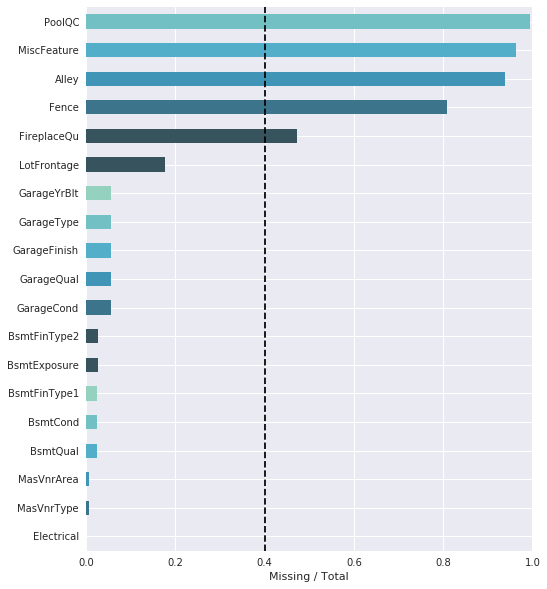

In [5]:
high_missing = helper.missing(df_original, limit=0.4, plot=True)
high_missing

### Transform the data

#### Remove irrelevant features

In [6]:
df = df_original.copy()  # modified dataset

# remove non-significant and high-missing features
droplist = ['Id'] + high_missing

assert len(set(droplist).intersection(set(target))) == 0, 'Targets cannot be dropped'

df.drop(droplist, axis='columns', inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [7]:
numerical = list(df.select_dtypes(include=[np.number]))

df = helper.classify_data(df, target, numerical=numerical)

helper.get_types(df)

Numerical features: 	36
Categorical features: 	38
Target: 		SalePrice (float32)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,category,category,category,category,category,category,category,category,category,float32


#### Remove low frequency values from categorical features

In [8]:
df, dict_categories = helper.remove_categories(df, target, ratio=0.01)

#### Fill missing values
Numerical -> median, categorical -> mode

In [9]:
helper.fill_simple(df, target, inplace=True)

### Visualize the data

#### Target vs some significant features

(34900.0, 600000)

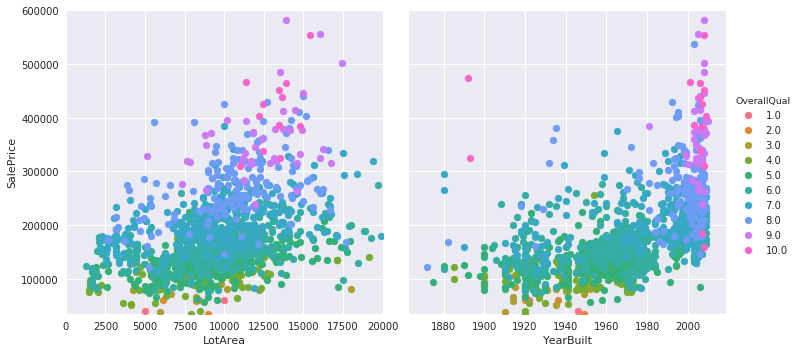

In [10]:
g = sns.PairGrid(
    df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], size=5, hue='OverallQual')
g.map(plt.scatter).add_legend()
g.axes[0, 0].set_xlim(0, 20000)
plt.ylim(df['SalePrice'].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

#### Categorical features

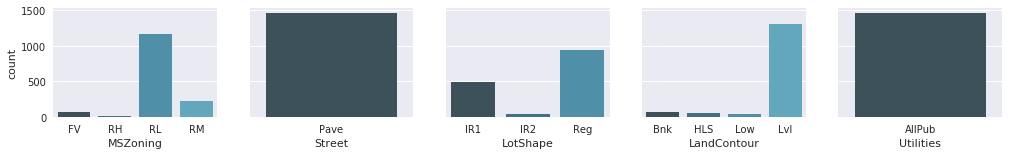

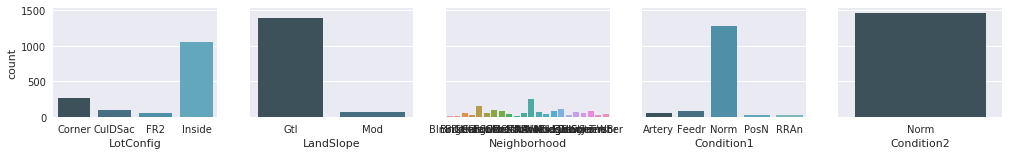

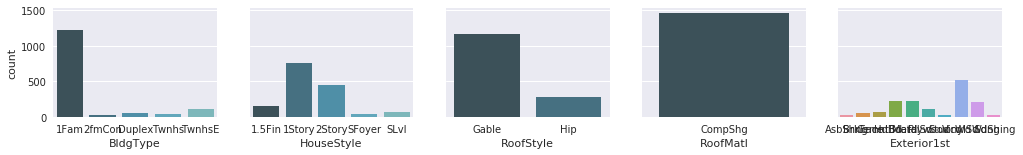

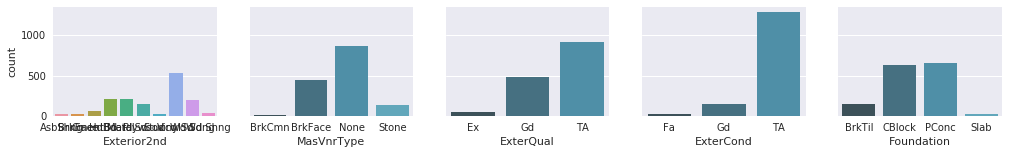

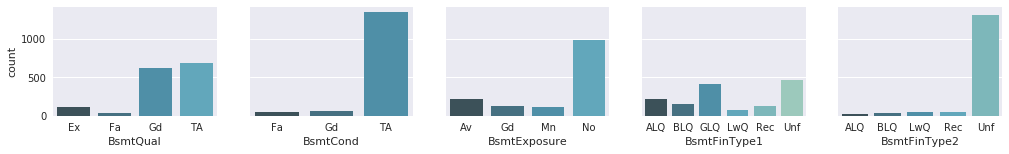

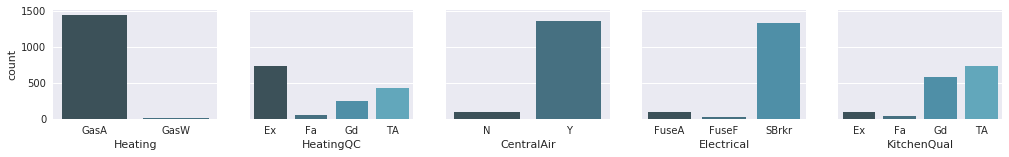

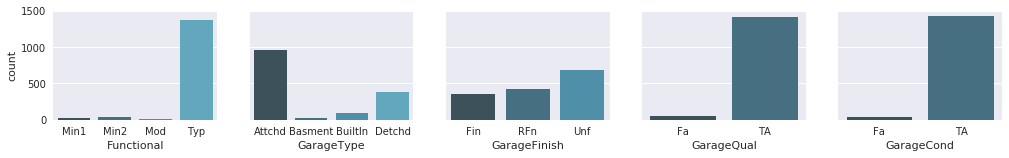

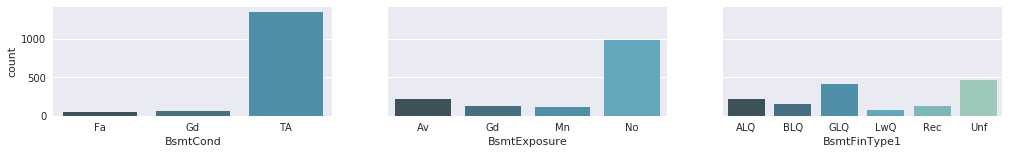

In [11]:
helper.show_categorical(df, sharey=True)

#### Target vs Categorical features

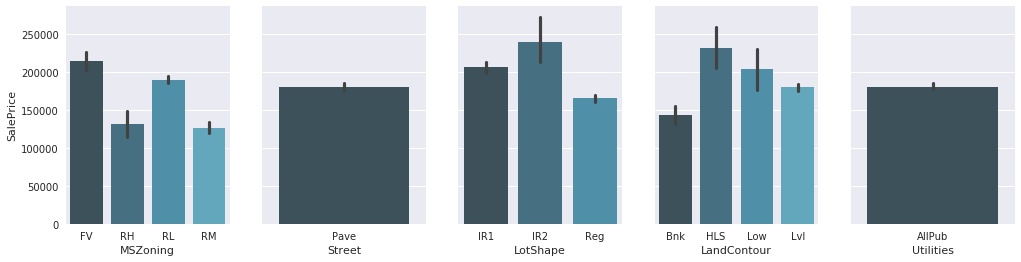

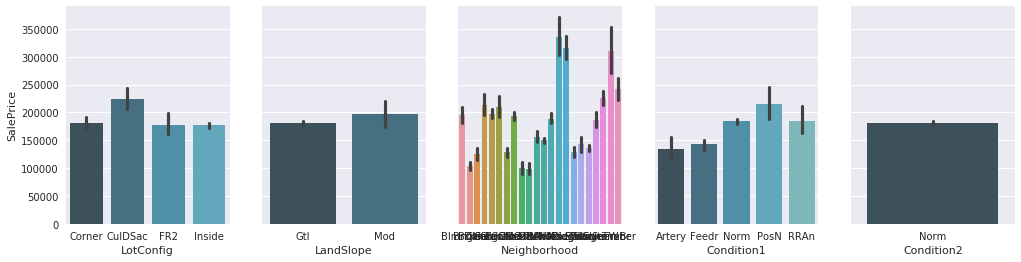

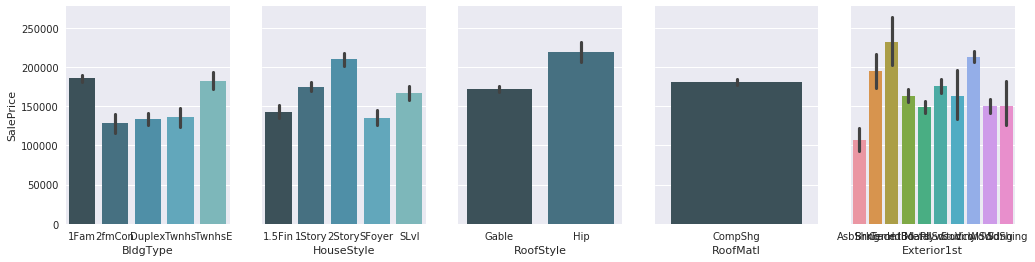

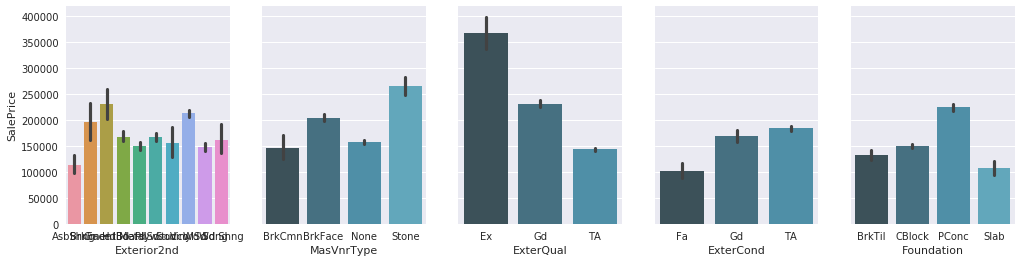

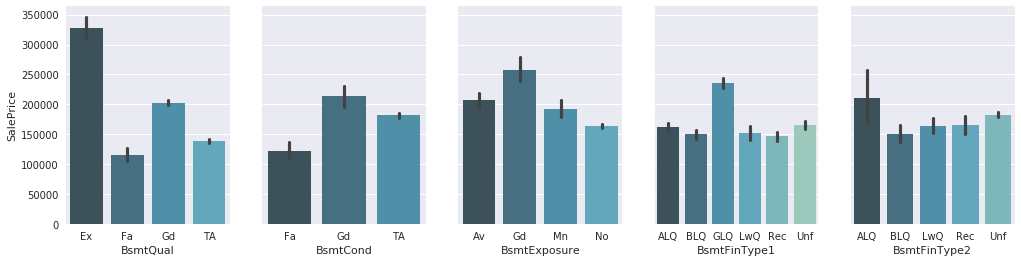

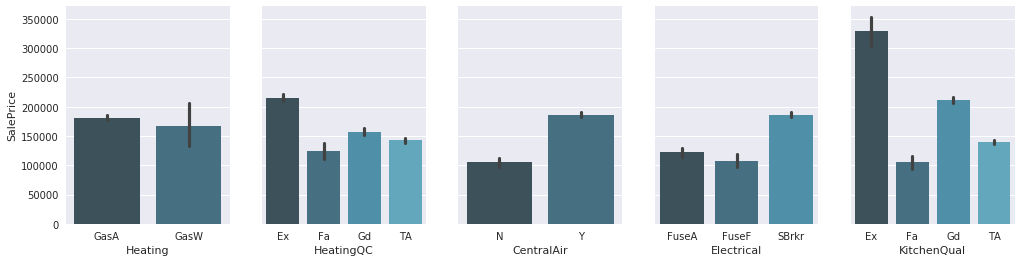

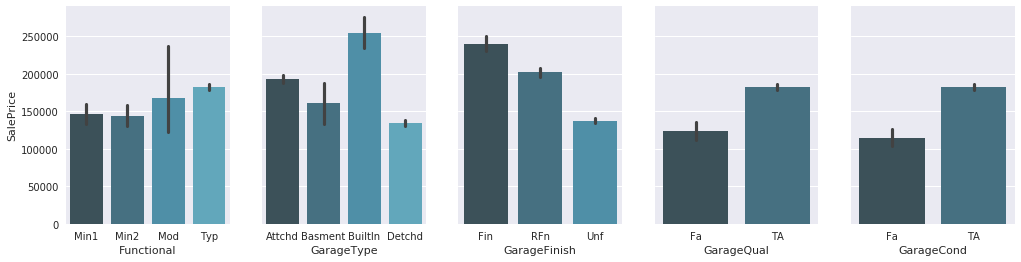

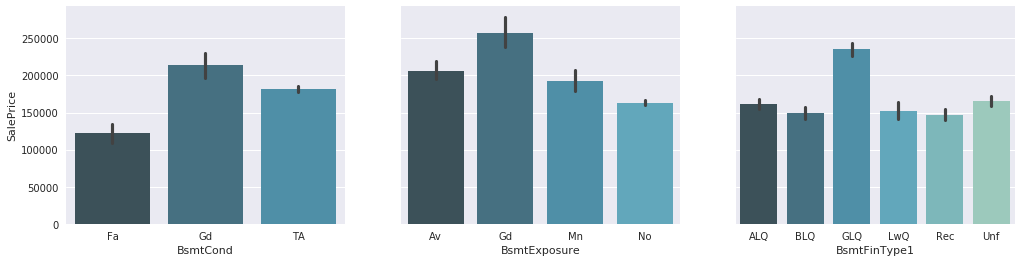

In [12]:
helper.show_target_vs_categorical(df, target)

#### Numerical features

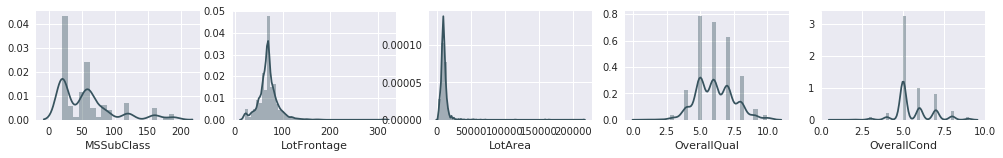

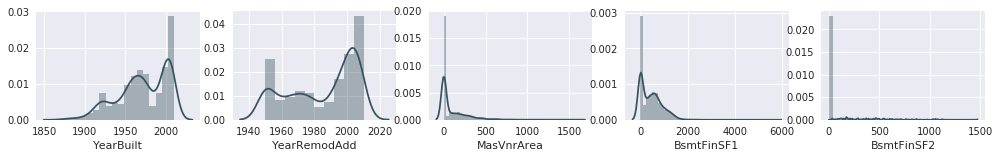

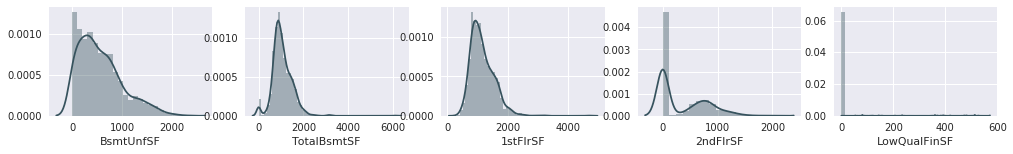

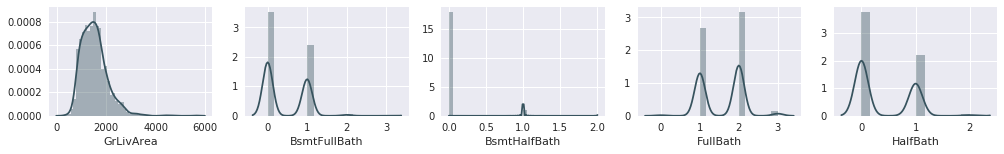

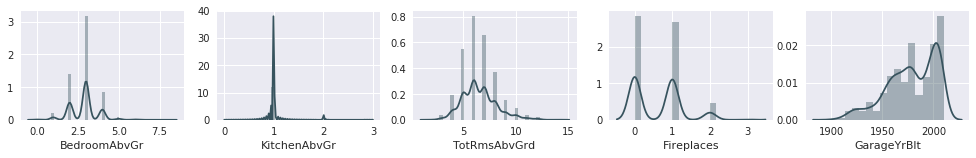

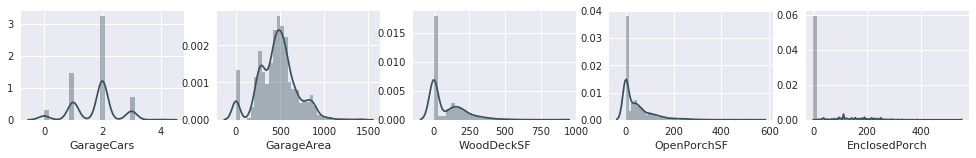

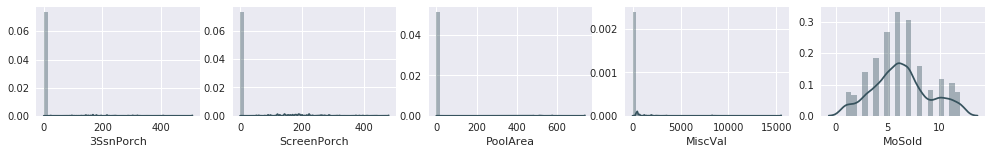

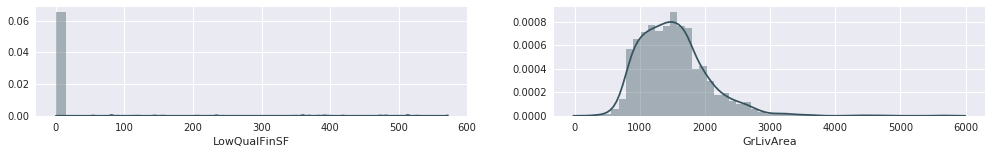

In [13]:
helper.show_numerical(df, kde=True)

#### Target vs Numerical features

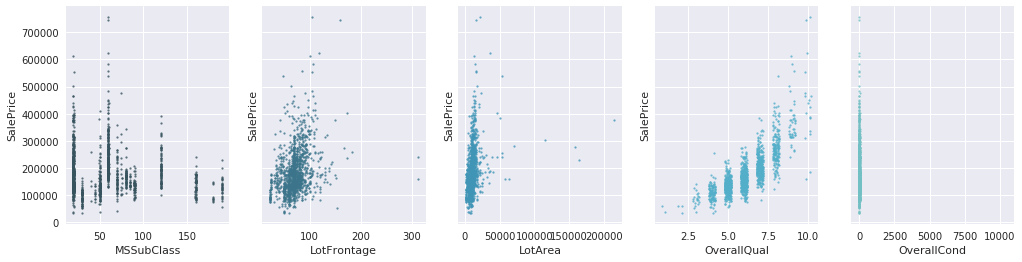

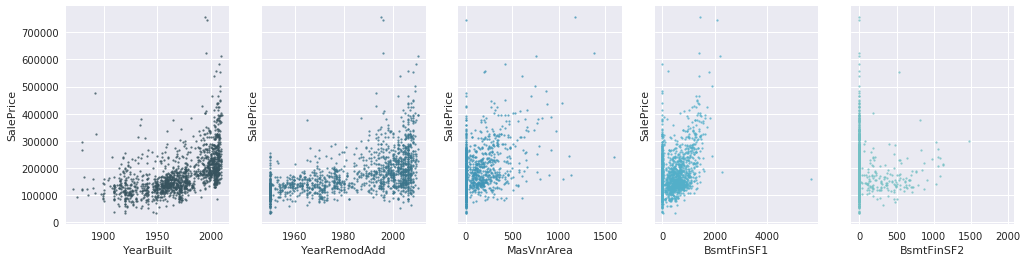

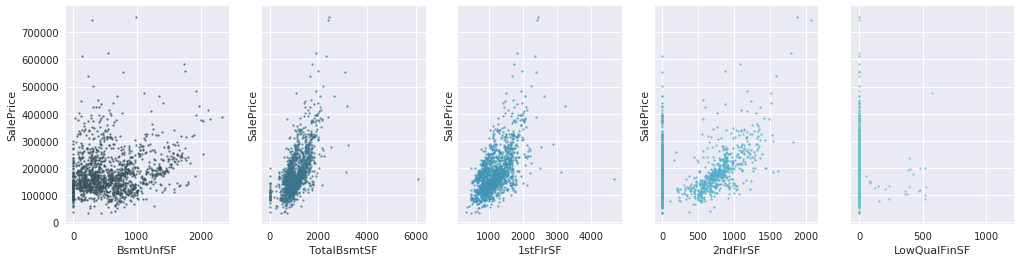

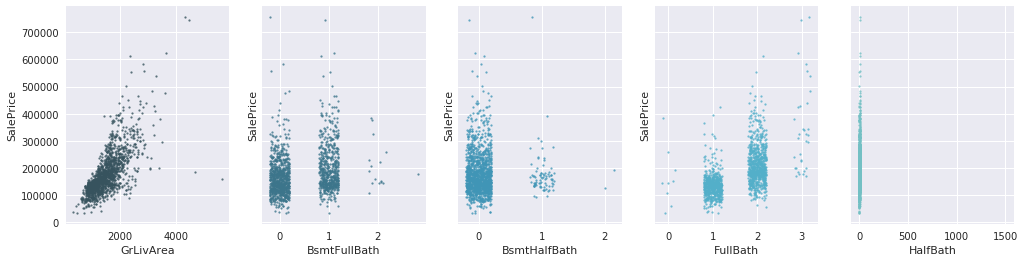

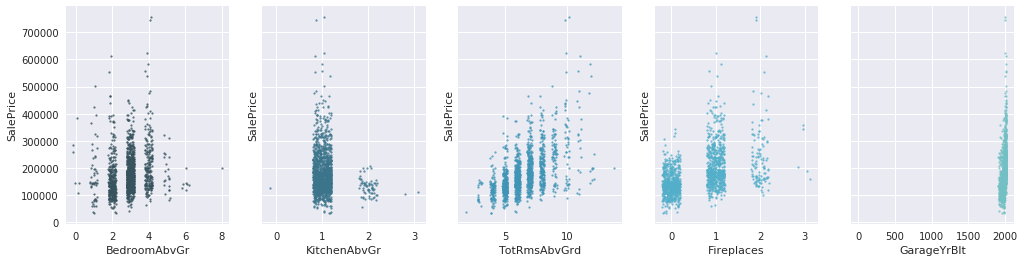

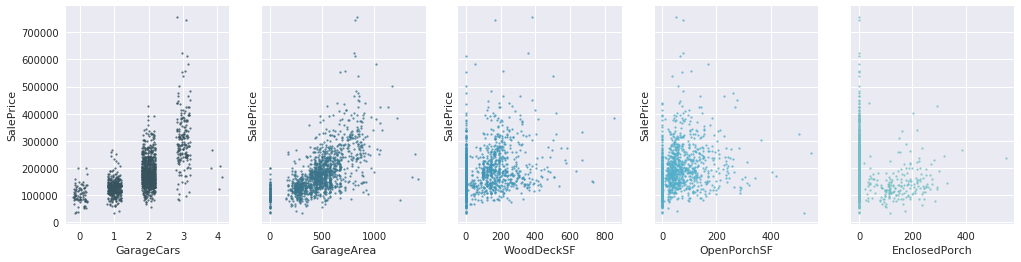

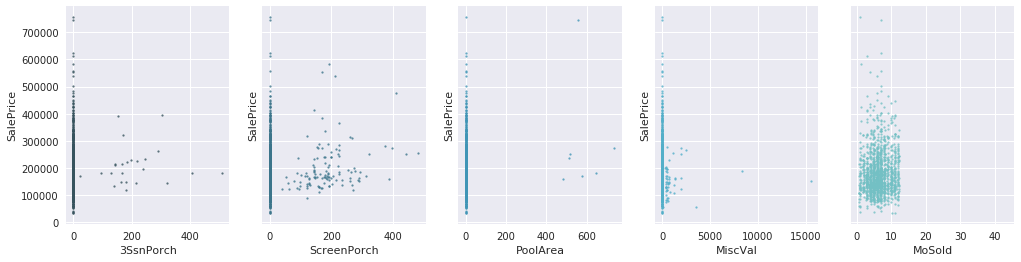

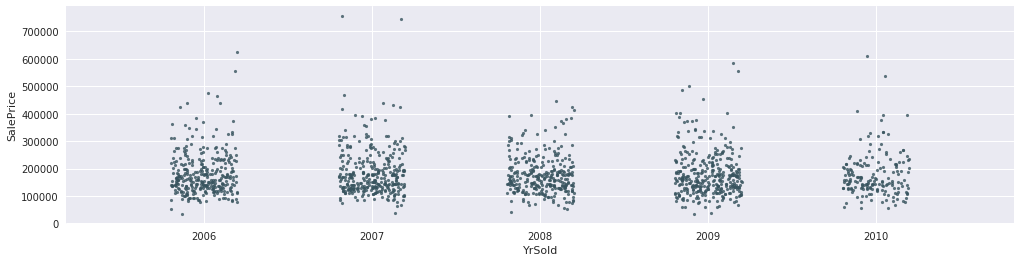

In [14]:
helper.show_target_vs_numerical(df, target, point_size=20,
        jitter=0.2,
        fit_reg=False)

#### Correlation between numerical features and target

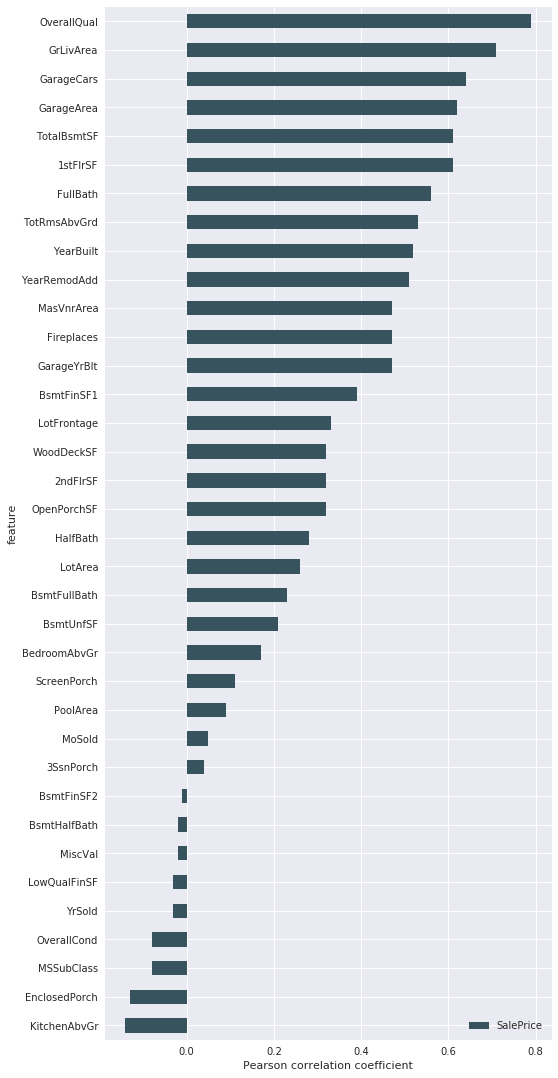

In [15]:
helper.correlation(df, target)

## 2. Neural Network model

### Select the features

In [16]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis='columns', inplace=True)
data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [17]:
data, scale_param = helper.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [18]:
data, dict_dummies = helper.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target] # sorted neural network inputs

data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073350,-0.220800,-0.207071,0.651256,-0.517023,1.050633,0.878369,0.513928,0.575228,-0.288554,...,0,0,1,0,0,1,0,0,1,0
1,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429428,-0.570555,1.171591,-0.288554,...,0,0,1,0,0,1,0,0,1,0
2,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984414,0.829932,0.325803,0.092875,-0.288554,...,0,0,1,0,0,1,0,0,1,0


### Split the data into training, validation, and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [19]:
test_size = 0.2
val_size = 0.1
random_state = 9

x_train, y_train, x_val, y_val, x_test, y_test = helper.train_val_test_split(
    data, target, test_size=test_size, val_size=val_size, random_state=random_state)

train size 	 X:(1051, 192) 	 Y:(1051, 1)
validation size	 X:(117, 192) 	 Y:(117, 1)
test size  	 X:(292, 192) 	 Y:(292, 1) 


One-hot encode the output not needed for regression

### Build and Train the Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                18528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 97        
Total params: 18,625
Trainable params: 18,625
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 9.7 s


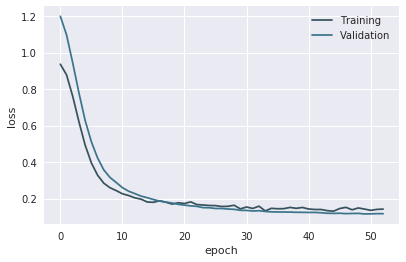


Training loss:  	0.1420
Validation loss: 	0.1169

Model saved at models/house_prices.h5
Training   R2-score: 	0.873
Validation R2-score: 	0.904


In [20]:
model_path = os.path.join("models", "house_prices.h5")

weights = weights = keras.initializers.TruncatedNormal(stddev=0.0001)
opt = keras.optimizers.adam(lr=0.00005)

model = None
model = helper.build_nn_reg(
    x_train.shape[1],
    y_train.shape[1],
    hidden_layers=1,
    input_nodes=x_train.shape[1] // 2,
    dropout=0.2,
    kernel_initializer=weights,
    bias_initializer=weights,
    optimizer=opt,
    summary=True)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)]

helper.train_nn(
    model,
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    path=model_path,
    epochs=500,
    batch_size=16,
    callbacks=callbacks)

from sklearn.metrics import r2_score

ypred_train = model.predict(x_train)
ypred_val = model.predict(x_val)
print('Training   R2-score: \t{:.3f}'.format(r2_score(y_train, ypred_train)))
print('Validation R2-score: \t{:.3f}'.format(r2_score(y_val, ypred_val)))

### Train with Cross Validation

In [21]:
# restore training set
x_train = np.vstack((x_train, x_val))  
y_train = np.vstack((y_train, y_val))

In [22]:
from sklearn.model_selection import KFold


def cv_train_nn(x_train, y_train, n_splits):
    """ Create and Train models for cross validation. Return best model """

    skf = KFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_loss = float('inf')

    print('Training {} models for Cross Validation ...'.format(n_splits))

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = helper.build_nn_reg(
            x_train.shape[1],
            y_train.shape[1],
            hidden_layers=1,
            input_nodes=x_train.shape[1] // 2,
            dropout=0.2,
            kernel_initializer=weights,
            bias_initializer=weights,
            optimizer=opt,
            summary=False)

        history = helper.train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]),
            epochs=500,
            batch_size=16,
            callbacks=callbacks)

        val_loss = history.history['val_loss'][-1]

        score.append(val_loss)

        if val_loss < best_loss:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_loss = val_loss

    print('\nCross Validation loss: {:.3f}'.format(np.mean(score)))
    return best_model


model = cv_train_nn(x_train, y_train, 10)

Training 10 models for Cross Validation ...

Cross Validation loss: 0.149


### Evaluate the model

In [23]:
y_pred_test = model.predict(x_test, verbose=0)
helper.regression_scores(y_test, y_pred_test, return_dataframe=True, index="DNN")

,Loss,R2 Score
DNN,0.15,0.86


### Make predictions

SalePrice . Prediction error:
Mean: 	 0.36%
Stddev:  10.88%


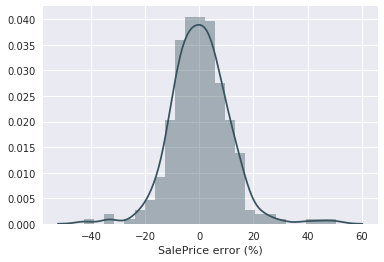

In [24]:
def predict_nn(model, x_test, target):
    """ Return a dataframe with actual and predicted targets in original scale"""

    for t in target:
        pred = model.predict(x_test, verbose=0)
        restore_pred = pred * scale_param[t][1] + scale_param[t][0]
        restore_pred = restore_pred.round()

        restore_y = y_test * scale_param[t][1] + scale_param[t][0]
        restore_y = restore_y.round()

        pred_label = 'Predicted_' + t
        error_label = t + ' error (%)'

        pred_df = pd.DataFrame({t: np.squeeze(restore_y), pred_label: np.squeeze(restore_pred)})

        pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

        print(t, ". Prediction error:")
        print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
        print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
        sns.distplot(pred_df[error_label])

    return pred_df


pred_df = predict_nn(model, x_test, target)

In [25]:
pred_df.head(10)

,Predicted_SalePrice,SalePrice,SalePrice error (%)
0,211204.0,151400.0,39.5
1,218395.0,241500.0,-9.6
2,78951.0,82000.0,-3.7
3,168806.0,162000.0,4.2
4,146216.0,140000.0,4.4
5,216865.0,227000.0,-4.5
6,257858.0,228950.0,12.6
7,191627.0,208300.0,-8.0
8,122705.0,128500.0,-4.5
9,170845.0,165000.0,3.5


The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of < 12%. Thus, ~95% of the houses are predicted within a price error < 24% respect to the actual one. 

Note: there is data leakage when removing low-frequency categorical values and scaling numerical features


### Compare with classical ML

In [26]:
helper.ml_regression(x_train, y_train[:,0], x_test, y_test[:,0])

Linear
Bayesian Ridge
Decision Tree
KNeighbors
AdaBoost
Random Forest


,Time (s),Test loss,Test R2 score
Random Forest,1.8,0.12,0.89
Linear,0.0,0.14,0.87
Bayesian Ridge,0.0,0.15,0.86
AdaBoost,0.3,0.17,0.84
Decision Tree,0.0,0.22,0.80
KNeighbors,0.0,0.29,0.74


####  Best tree-based model

In [27]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(
    n_jobs=-1, n_estimators=100, random_state=9).fit(x_train, np.ravel(y_train))

y_pred = random_forest.predict(x_test)

helper.regression_scores(y_test, y_pred, return_dataframe=True, index="Random Forest")

,Loss,R2 Score
Random Forest,0.12,0.89


#### Feature importances

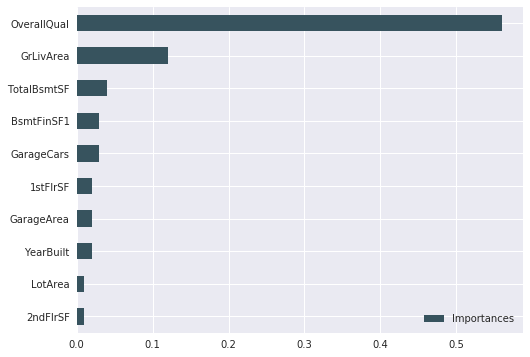

In [28]:
 results = helper.feature_importances(model_features, random_forest)